In [1]:
from astropy.table import Table, join, Column, setdiff
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from myprogs.vlbi.sou_func import read_sou
from myprogs.catalog.pos_diff import radio_cat_diff_calc
from myprogs.catalog.read_icrf import read_icrf3
from myprogs.vlbi.sou_func import read_crf
%matplotlib inline

In [2]:
icrf3 = read_icrf3(wv="sx")

nju2021a = read_sou(
    "/Users/Neo/Astronomy/data/vlbi/nju/global/2021/nju2021a.sou",)
#     drop_few_obs=True,
#     nobs_lim=3)
# opa2019a = read_crf("../data/ivs-solutions/opa2021a.crf",
#                     drop_few_obs=True,
#                     analy_cen="opa")

In [11]:
nju2021a[nju2021a["iers_name"] == "2250+190"]

ivs_name,j2000_name,iers_name,class,ra,ra_err,dec,dec_err,ra_dec_corr,pos_err,num_obs,total_obs,num_ses,total_ses,beg_epoch,end_epoch,mean_epoch
,,,,deg,mas,deg,mas,,mas,,,,,MJD,MJD,MJD
str8,str10,str8,str1,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64
2250+194,J2253+1942,2250+190,C,343.280704861375,0.012238381199472374,19.709619082583334,0.0191,-0.177,0.019300157864931774,9405,11162,245,263,50084.0,59318.0,54701.0


In [4]:
# Calculate the positional difference of 'opa2019a - ICRF3'
# catdif1 = radio_cat_diff_calc(opa2019a, icrf3, sou_name="iers_name")

# Calculate the positional difference of 'nju2021a - ICRF3'
catdif1 = radio_cat_diff_calc(nju2021a, icrf3, sou_name="iers_name")

In [5]:
icrf3_def = icrf3[icrf3["type"] == "D"]

In [6]:
nju_def = join(nju2021a, icrf3_def, keys="iers_name")

In [7]:
setdiff(icrf3_def, nju_def, keys="iers_name")

icrf_name,iers_name,type,ra,dec,ra_err,dec_err,ra_dec_corr,mean_obs,pos_err_max,pos_err_min,eepa,beg_obs,end_obs,nb_sess,nb_del
,,,deg,deg,mas,mas,,,mas,mas,deg,,,,
str21,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64


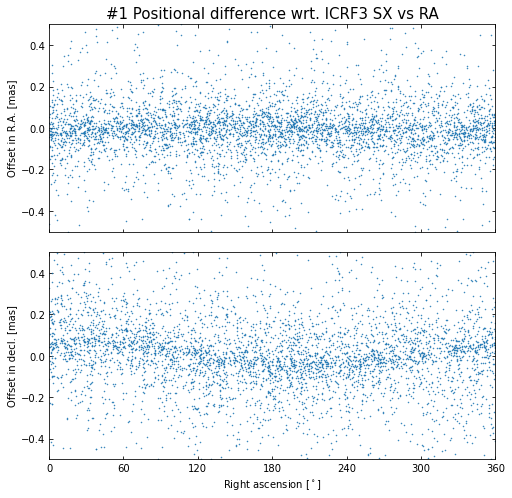

In [8]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(catdif1["ra"], catdif1["dra"], ".", ms=1)
ax1.plot(catdif1["ra"], catdif1["ddec"], ".", ms=1)

ax1.set_xlabel("Right ascension [$^\circ$]")
ax0.set_ylabel("Offset in R.A. [mas]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("#1 Positional difference wrt. ICRF3 SX vs RA", fontsize=15)

plt.subplots_adjust(hspace=0.1)

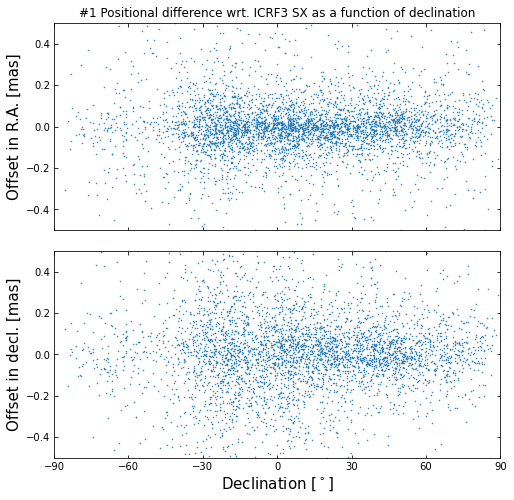

In [9]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(catdif1["dec"], catdif1["dra"], ".", ms=1)
ax1.plot(catdif1["dec"], catdif1["ddec"], ".", ms=1)

ax1.set_xlabel("Declination [$^\circ$]", fontsize=15)
ax0.set_ylabel("Offset in R.A. [mas]", fontsize=15)
ax1.set_ylabel("Offset in decl. [mas]", fontsize=15)

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title(
    "#1 Positional difference wrt. ICRF3 SX as a function of declination")

plt.subplots_adjust(hspace=0.1)
# plt.savefig("offset-dec.png")

In [10]:
# My modules
from myprogs.catalog.vsh_deg2_cor import vsh_deg02_fitting

# Transform columns into np.array
dra1 = np.array(catdif1["dra"])
ddec1 = np.array(catdif1["ddec"])
dra_err1 = np.array(catdif1["dra_err"])
ddec_err1 = np.array(catdif1["ddec_err"])
ra_rad1 = np.array(catdif1["ra"].to(u.radian))
dec_rad1 = np.array(catdif1["dec"].to(u.radian))
dra_ddec_cov1 = np.array(catdif1["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
par1, sig1, _ = vsh_deg02_fitting(dra1,
                                  ddec1,
                                  ra_rad1,
                                  dec_rad1,
                                  dra_err1,
                                  ddec_err1,
                                  cov=dra_ddec_cov1,
                                  elim_flag="None")
#     elim_flag="None")

# mas -> uas
par1 = par1 * 1.e3
sig1 = sig1 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "             x             y             z"
      "             x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" % (
          dra1.size,
          par1[3],
          sig1[3],
          par1[4],
          sig1[4],
          par1[5],
          sig1[5],
          par1[0],
          sig1[0],
          par1[1],
          sig1[1],
          par1[2],
          sig1[2],
      ))

quad_names = Column([
    "ER22", "EI22", "ER21", "EI21", "E20", "MR22", "MI22", "MR21", "MI21",
    "M20"
])

print("Positional difference")
t_quad1 = Table([quad_names, par1[6:], sig1[6:]],
                names=["Quadrupolar term", "Estimate", "Error"])
t_quad1["Estimate"].format = "%5.0f"
t_quad1["Error"].format = "%5.0f"
print(t_quad1)

Estimates (  4527 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
             x             y             z             x             y             z
--------------------------------------------------------------------------------------------
         +25 +/- 268   -47 +/- 263    -7 +/- 203          +1 +/- 244    -5 +/- 242   +12 +/- 262
--------------------------------------------------------------------------------------------

Positional difference
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -2   134
            EI22       -0   135
            ER21       -2   303
            EI21        2   315
             E20        4   299
            MR22        4   157
            MI22        0   158
            MR21       -3   292
            MI21        0   301
             M20        5   245
